<a href="https://colab.research.google.com/github/csabiu/Astrostatistics/blob/main/astrostats_sdss_2pcf_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will guide you through a realistic analysis of galaxy survey data.
We will download real data and then measure its 2-point correlation function.

In [2]:
import scipy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10.0, 10.0]})

### Download SDSS eBOSS DR12 CMASS data and random catalogs
search in https://data.sdss.org/sas/ for other catalogues if you want to try a different target eg, ELG, QSO - or even newer eBOSS data!

In [3]:
!wget https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASS_South.fits.gz
!wget https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASS_South.fits.gz

--2024-04-16 04:15:48--  https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASS_South.fits.gz
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1172229517 (1.1G) [application/octet-stream]
Saving to: ‘random0_DR12v5_CMASS_South.fits.gz’

random0_DR12v5_CMAS 100%[===================>]   1.09G  69.4MB/s    in 17s     

2024-04-16 04:16:05 (67.3 MB/s) - ‘random0_DR12v5_CMASS_South.fits.gz’ saved [1172229517/1172229517]

--2024-04-16 04:16:05--  https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASS_South.fits.gz
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51580500 (49M) [application/octet-stream]
Saving to: ‘galaxy_DR12v5_CMASS_South.fits.gz’

galaxy_DR12v5_CMASS 100%[===================>]  49.19M  

### Extract relavent columns from the fits file
Angular positions (RA, dec), redshift (z) and weights

In [5]:
hdul = fits.open('galaxy_DR12v5_CMASS_South.fits.gz')

ra=hdul[1].data['RA']
dec=hdul[1].data['DEC']
z=hdul[1].data['Z']
wtot=hdul[1].data['WEIGHT_SYSTOT']
wcp=hdul[1].data['WEIGHT_CP']
wnoz=hdul[1].data['WEIGHT_NOZ']
wfkp=hdul[1].data['WEIGHT_FKP']
wgal=wtot*wfkp*(wcp+wnoz-1.0) #Eq 2 from https://arxiv.org/pdf/1607.03154.pdf


### Plot the redshift distribution

mean redshift of the galaxies : 0.5426714


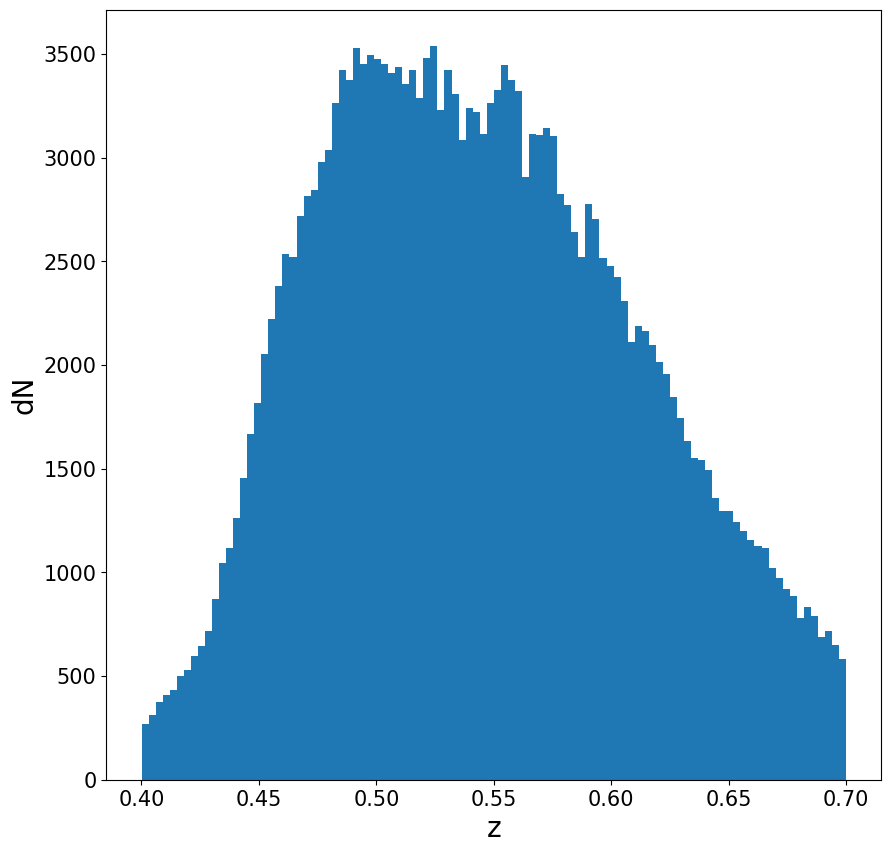

In [6]:
ind=np.where((z>0.4) & (z<0.7)) #cut the redshift range
plt.hist(z[ind],100)
plt.xlabel('z',fontsize=20)
plt.ylabel('dN',fontsize=20)
print("mean redshift of the galaxies :",np.mean(z))

Text(0, 0.5, 'dec')

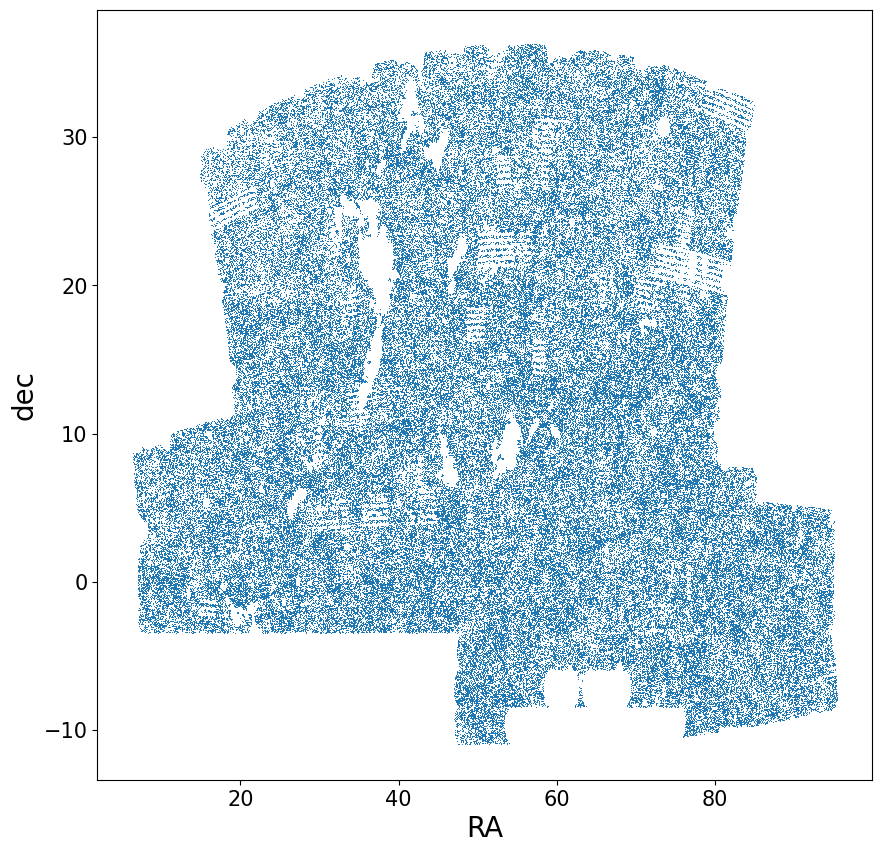

In [7]:
plt.figure(figsize=(10,10))
plt.plot(np.mod(ra+50,360),dec,',')
plt.xlabel('RA',fontsize=20)
plt.ylabel('dec',fontsize=20)

## Use astropy to convert from angle and redshift to cartesean comoving x,y,z positions

In [8]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.coordinates import SkyCoord

ind=np.where((z>0.4) & (z<0.7))
cosmo=FlatLambdaCDM(Om0=0.30,H0=100) # sets the cosmological model working in units Mpc/h with Ho=100
dist=cosmo.comoving_distance(z[ind]).value  # convert redshift to distance

c = SkyCoord(ra=ra[ind]*u.degree, dec=dec[ind]*u.degree, distance=dist*u.Mpc) # convert to x,y,z
data=np.transpose((c.cartesian.x,c.cartesian.y,c.cartesian.z))

### Load the Random Catalogue and repeat the same proceedure

In [9]:
hdul = fits.open('random0_DR12v5_CMASS_South.fits.gz')

ra=hdul[1].data['RA']
dec=hdul[1].data['DEC']
z=hdul[1].data['Z']
wrand=hdul[1].data['WEIGHT_FKP']

mean redshift of the randoms : 0.5433296495801546


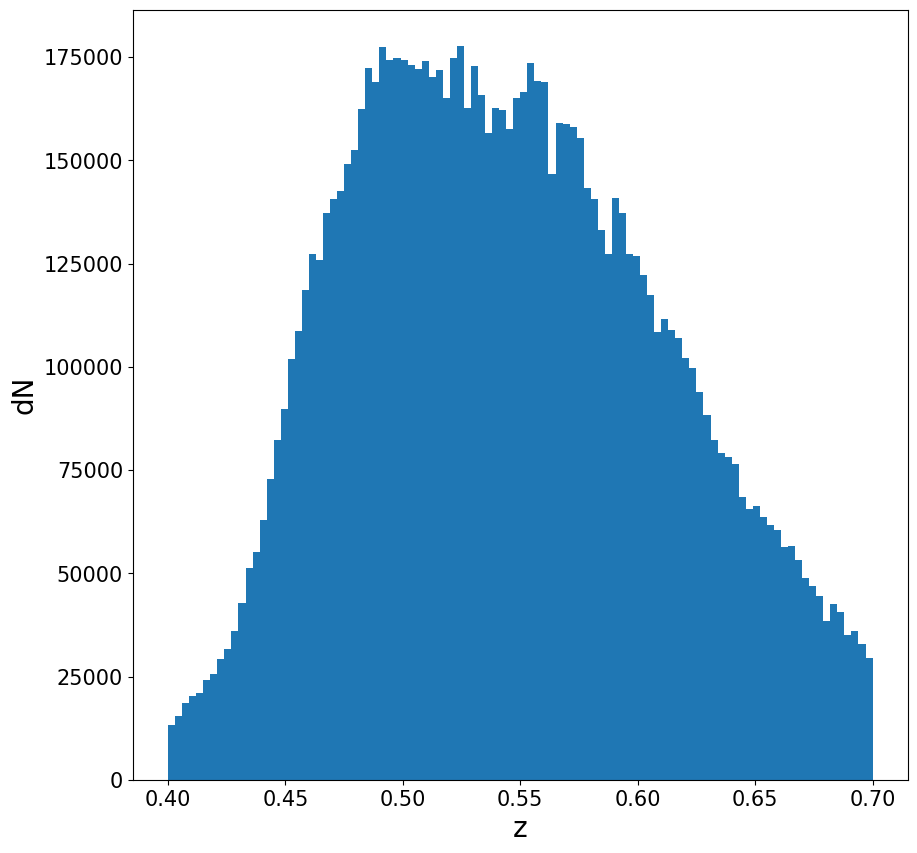

In [10]:
ind=np.where((z>0.4) & (z<0.7))
plt.hist(z[ind],100)
plt.xlabel('z',fontsize=20)
plt.ylabel('dN',fontsize=20)
print("mean redshift of the randoms :",np.mean(z))

Plotting the random point angular positions we see that they look almostly exactly like the galaxies as they should

Text(0, 0.5, 'dec')

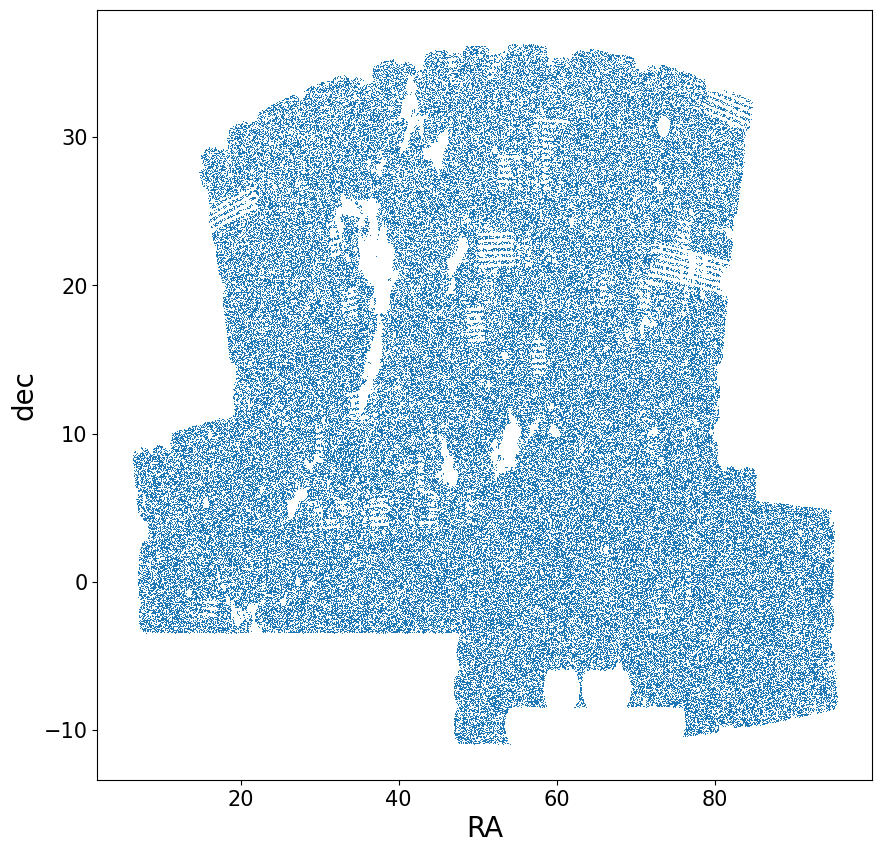

In [11]:
plt.figure(figsize=(10,10))
plt.plot(np.mod(ra[::50]+50,360),dec[::50],',') # plot a random sample 1/50
plt.xlabel('RA',fontsize=20)
plt.ylabel('dec',fontsize=20)

Convert to 3-D coordinates

In [12]:
dist=cosmo.comoving_distance(z[ind]).value

c = SkyCoord(ra=ra[ind]*u.degree, dec=dec[ind]*u.degree, distance=dist*u.Mpc)
rand=np.transpose((c.cartesian.x,c.cartesian.y,c.cartesian.z))
rand = rand[::50,:] # save a subsample of the data (1/50)

Sub-sample the data to make it faster - for testing

In [13]:
print("number of Galaxies:", np.shape(data)[0])
print("number of Randoms:", np.shape(rand)[0])

#lets down-sample by 1/30 to make this faster
data_s = data[::30,:]
rand_s= rand[::30,:]

print("number of downsampled Galaxies:", np.shape(data_s)[0])
print("number of downsampled Randoms:", np.shape(rand_s)[0])

number of Galaxies: 213205
number of Randoms: 214868
number of downsampled Galaxies: 7107
number of downsampled Randoms: 7163


# Measure the 2-point correlation function


1.   Count the number of pairs of galaxies (DD) where 40<r<50 Mpc
2.   Count the number of pairs of randoms (RR) where 40<r<50 Mpc
3.   Compute the simple statistic $\xi=\frac{DD}{RR}-1$
4.   Report TWO things: the xi value and the time it took. [0.0389,~8min]

In [56]:
import time #for timing
from tqdm import tqdm #progress bar

start= time.time()
nd=np.shape(data_s)[0]
DD=0
for i in tqdm(range(nd)): # this is how you use the progress bar
  for j in range(i+1,nd):
    dist=np.sqrt(np.sum((data_s[i,:]-data_s[j,:])**2))
    if(dist>40. and dist<50.):
      DD=DD+1.

end= time.time()

print("\n time:",end-start)

100%|██████████| 7107/7107 [03:33<00:00, 33.36it/s] 


 this is how you time something: 213.03914856910706


In [55]:
start= time.time()
nd=np.shape(rand_s)[0]
RR=0
for i in tqdm(range(nd)): # this is how you use the progress bar
  for j in range(i+1,nd):
    dist=np.sqrt(np.sum((rand_s[i,:]-rand_s[j,:])**2))
    if(dist>40. and dist<50.):
      RR=RR+1.

end= time.time()

print("\n this is how you time something:",end-start)

100%|██████████| 7163/7163 [03:45<00:00, 31.74it/s] 


 this is how you time something: 225.68899703025818


This is how you normalise

In [57]:
nd=np.shape(data_s)[0]
DD_n=DD/(nd*(nd-1.))
DD_n

nd=np.shape(rand_s)[0]
RR_n=RR/(nd*(nd-1.))
RR_n

print('xi:',DD_n/RR_n - 1.)

xi: 0.05533943098253169


How do the algorithms runtime scale with number of data points?
How long would it take your algorithm to work on 1M data points?

In [93]:
res=[]
for k in [30,40,50,60]:
  data_s = data[::k,:]

  start= time.time()
  nd=np.shape(data_s)[0]
  DD=0
  for i in tqdm(range(nd)): # this is how you use the progress bar
    for j in range(i+1,nd):
      dist=np.sqrt(np.sum((data_s[i,:]-data_s[j,:])**2))
      if(dist>40. and dist<50.):
        DD=DD+1.

  end= time.time()
  res.append((nd,end-start))

100%|██████████| 3554/3554 [00:53<00:00, 66.97it/s] 


Text(0, 0.5, 'time')

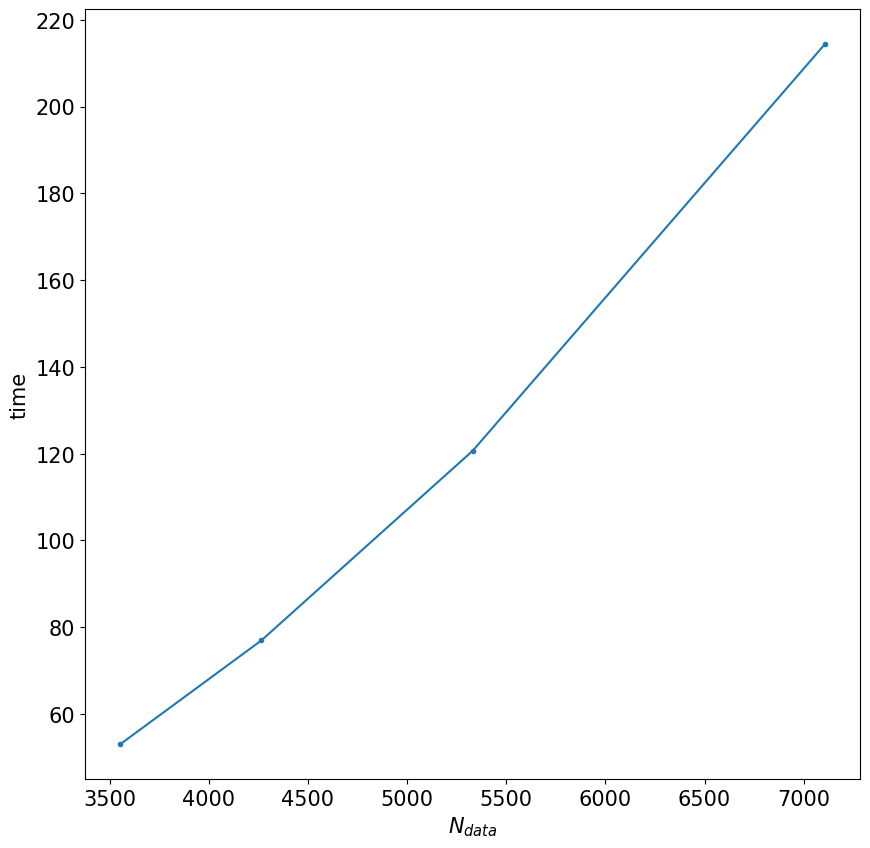

In [94]:
res=np.asarray(res)

plt.plot(res[:,0],res[:,1],'.-')
plt.xlabel('$N_{data}$')
plt.ylabel('time')

Lets find the trend line for this...

In [80]:
new_x=np.arange(2000,10000,1000)
coefs = np.polyfit(res[:,0],res[:,1],2)
new_line = np.polyval(coefs, new_x)

Text(0, 0.5, 'time')

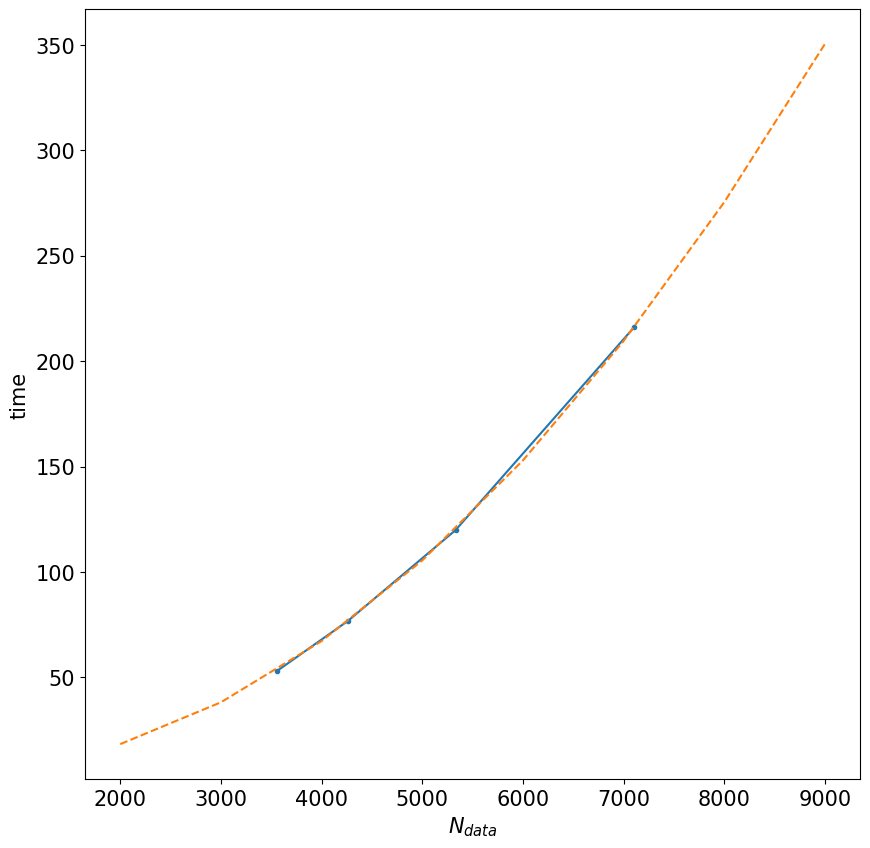

In [81]:
plt.plot(res[:,0],res[:,1],'.-')
plt.plot(new_x,new_line,'--')
plt.xlabel('$N_{data}$')
plt.ylabel('time')

Modern Galaxy surveys consist of more than a million galaxies, LSST will reach 1 billion. So how long would it take to analyse?

Text(0, 0.5, 'time')

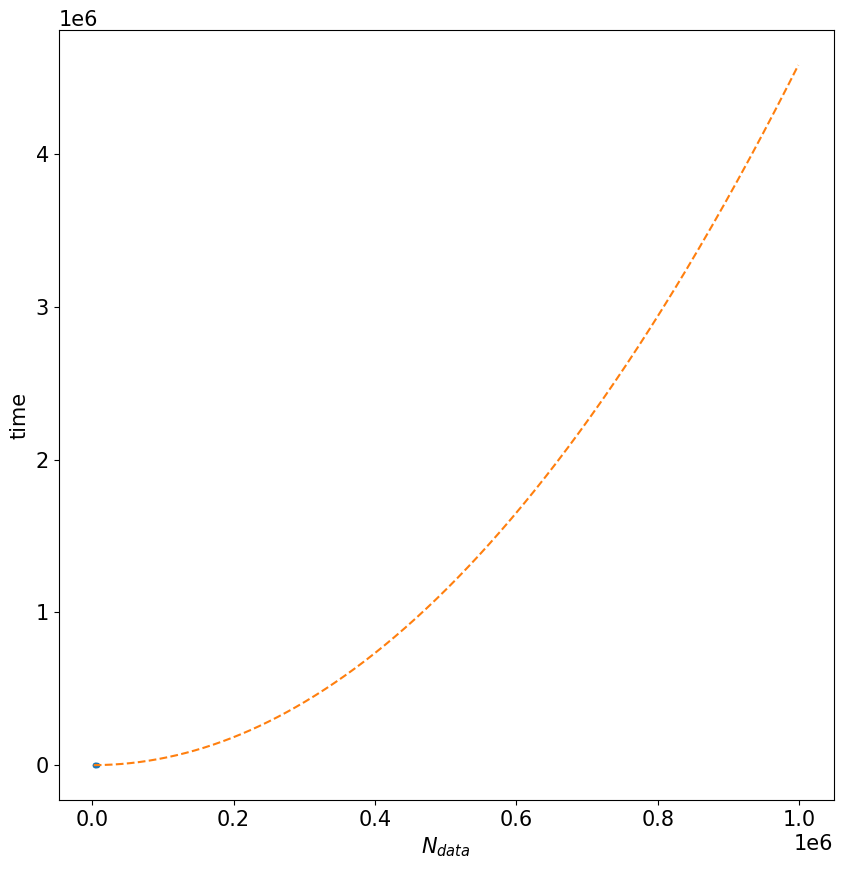

In [82]:
new_x=np.arange(2000,1000000,1000)
coefs = np.polyfit(res[:,0],res[:,1],2)
new_line = np.polyval(coefs, new_x)

plt.plot(res[:,0],res[:,1],'.-')
plt.plot(new_x,new_line,'--')
plt.xlabel('$N_{data}$')
plt.ylabel('time')

In [87]:
print('time in days: ',4e6/60/60/24)

time in days:  46.2962962962963


Lets try a kd-tree!

In [28]:
from scipy.spatial import KDTree


In [53]:
start= time.time()

nd=np.shape(data_s)[0]
DDt=0.
tree = KDTree(data_s)
res_u=tree.query_ball_point(data_s,r=50.)
res_l=tree.query_ball_point(data_s,r=40.)

for i in range(nd):
  DDt=DDt+np.setxor1d(res_u[i],res_l[i]).shape[0]


end= time.time()
print("\n time for DD:",end-start)

start= time.time()

nd=np.shape(rand_s)[0]
RRt=0.
tree = KDTree(rand_s)
res_u=tree.query_ball_point(rand_s,r=50.)
res_l=tree.query_ball_point(rand_s,r=40.)

for i in range(nd):
  RRt=RRt+np.setxor1d(res_u[i],res_l[i]).shape[0]


end= time.time()
print("\n time for RR:",end-start)


 this is how you time something: 0.5138459205627441

 this is how you time something: 0.46822166442871094


In [54]:
nd=np.shape(data_s)[0]
DDt_n=DDt/(nd*(nd-1.))
DDt_n

nd=np.shape(rand_s)[0]
RRt_n=RRt/(nd*(nd-1.))
RRt_n

print('xi:',DDt_n/RRt_n - 1.)

xi: 0.05533943098253169


Lets check how this algorithm scales with N data

In [91]:
res=[]
for k in [2,5,10,20,40]:
  data_s = data[::k,:]

  start= time.time()
  nd=np.shape(data_s)[0]
  DDt=0.
  tree = KDTree(data_s)
  res_u=tree.query_ball_point(data_s,r=50.)
  res_l=tree.query_ball_point(data_s,r=40.)

  for i in range(nd):
    DDt=DDt+np.setxor1d(res_u[i],res_l[i]).shape[0]

  end= time.time()
  res.append((nd,end-start))

Text(0, 0.5, 'time')

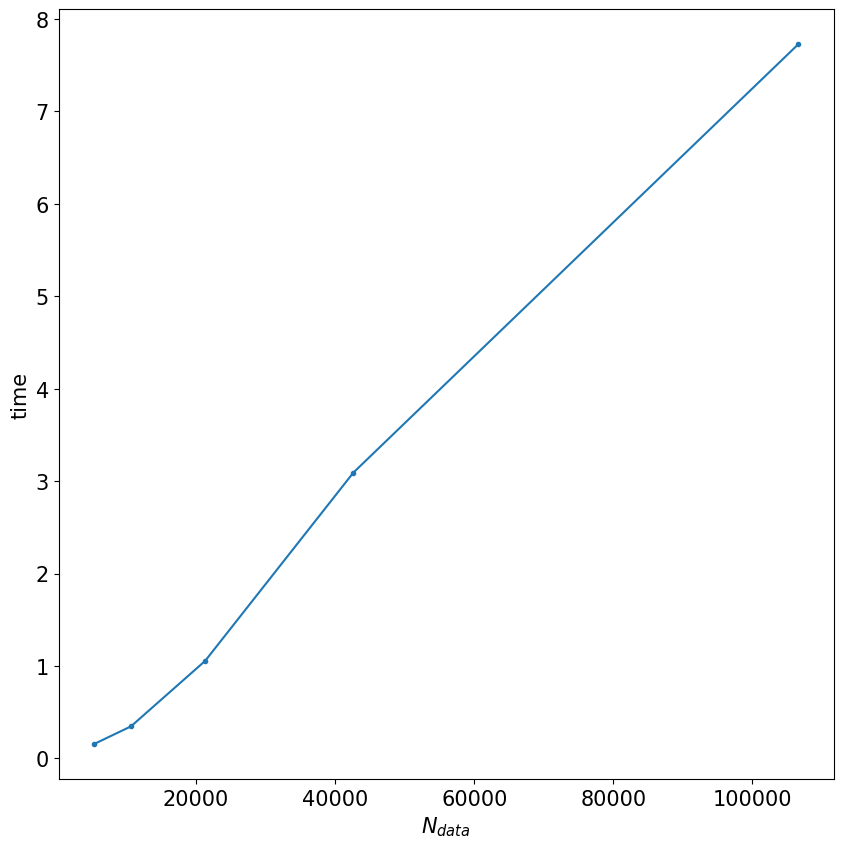

In [92]:
res=np.asarray(res)

plt.plot(res[:,0],res[:,1],'.-')
plt.xlabel('$N_{data}$')
plt.ylabel('time')